# 分布式函数
:label:`remote-function`

被 Ray 加速的函数可以被运行在远程的 Ray 集群上，被称为远程函数（Remote Function）又被称为任务（Task）。Remote Function 是无状态的，无状态的意思是的执行只依赖函数的输入和输出，不依赖其他第三方的中间变量。

### 顺序执行与分布式执行

一个原生的 Python 函数如果使用 `for` 循环多次执行，将以顺序的方式，依次执行，如 :numref:`serial-timeline` 所示。

![顺序执行的时间轴示意图](../img/ch-ray-core/serial-timeline.png)
:width:`800px`
:label:`serial-timeline`

与原生 Python 函数顺序不同的是，Ray 可以将函数的执行分布式到集群中的多个计算节点上，如 :numref:`distributed-timeline` 所示。

![分布式执行的时间轴示意图](../img/ch-ray-core/distributed-timeline.png)
:width:`800px`
:label:`distributed-timeline`

接下来将以三个案例来演示如何将 Python 函数横向扩展到 Ray 集群上：

* 生成斐波那契数列
* 使用蒙特卡洛方法计算 $\pi$
* 分布式图片处理

In [1]:
import logging
import math
import os
import random
import time
from pathlib import Path
from typing import List, Tuple
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torchvision
from torchvision import transforms as T
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

import ray

### 启动 Ray 集群

在正式使用 Ray 的分布式功能之前，首先要启动一个 Ray 集群。启动 Ray 集群的方式有很多种，我们可以使用 `ray.init()` 函数，先上启动一个单节点的 Ray 集群，以便后续的演示。这个单节点的 Ray 集群运行在执行这个 Python 任务的电脑上。

In [2]:
# Hide outputs
if ray.is_initialized:
    ray.shutdown()
ray.init(logging_level=logging.ERROR)

Python version:,3.10.9
Ray version:,2.3.0
Dashboard:,http://127.0.0.1:8267


### 案例1：斐波那契数列

接下来，我们用斐波那契数列的案例来演示如何使用 Ray 对 Python 函数进行分布式的扩展。

斐波那契数列的第 $n$ 项 $F_n$ 可以由它前面的两个数 $F_{n-1}$ 和 $F_{n-2}$ 计算得到。用形式化的数学公式定义为：

$$
F_n = F_{n-1} + F_{n-2}
$$

其中，$F_0 = 0$，$F_1 = 1$。

下面我们使用原生的 Python 定义一个斐波那契函数。

In [3]:
def generate_fibonacci(sequence_size):
    fibonacci = []
    for i in range(0, sequence_size):
        if i < 2:
            fibonacci.append(i)
            continue
        fibonacci.append(fibonacci[i-1] + fibonacci[i-2])
    return len(fibonacci)

如果我们想让这个 Python 函数被 Ray 分布式执行，只需要在函数上增加一个 `@ray.remote` 装饰器。

In [4]:
# 在函数上增加一个 @ray.remote 装饰器
@ray.remote
def generate_fibonacci_distributed(sequence_size):
    return generate_fibonacci(sequence_size)

作为 Ray 的使用者，我们不需要关心 Task 在 Ray 集群中是如何被分布式执行的，也不需要了解这个 Task 被调度到哪些计算节点。所有这些分布式执行的细节都被 Ray 所隐藏，或者说 Ray 帮我们做了底层的分布式与调度这些工作。

我们比较一下顺序执行与分布式执行的效率与耗时。`os.cpu_count()` 可以得到当前的 CPU 核心数。顺序执行的代码使用 `for` 循环，多次调用生成斐波那契数列的函数。

In [5]:
# 顺序执行
def run_local(sequence_size):
    results = [generate_fibonacci(sequence_size) for _ in range(os.cpu_count())]
    return results

使用 Ray 进行分布式扩展，函数可并行地在多个 CPU 核心上执行。

In [6]:
# 使用 Ray 进行分布式扩展
def run_remote(sequence_size):
    results = ray.get([generate_fibonacci_distributed.remote(sequence_size) for _ in range(os.cpu_count())])
    return results

In [7]:
SEQUENCE_SIZE = 200000

start = time.time()
run_local(SEQUENCE_SIZE)
end = time.time()
elapsed_fib_serial = end - start
print(f"Serial :: fibonacci sequence {SEQUENCE_SIZE} elapsed: {elapsed_fib_serial:.2f} sec")

start = time.time()
run_remote(SEQUENCE_SIZE)
end = time.time()
elapsed_fib_dist = end - start
print(f"Distributed :: fibonacci sequence {SEQUENCE_SIZE} elapsed: {elapsed_fib_dist:.2f} sec")

Serial :: fibonacci sequence 200000 elapsed: 17.70 sec


Distributed :: fibonacci sequence 200000 elapsed: 17.01 sec


这个例子中，计算复杂度不够大，你可以试着将 `SEQUENCE_SIZE` 改为更大的值，对比一下性能。

### 原生 Python 函数与 Ray 的区别

需要注意的是，使用 Ray 与原生 Python 函数稍有区别，主要体现在：

* 函数调用方式

原生 Python 函数，使用 `func_name()` 调用。在使用 Ray 时，函数定义需要增加 `@ray.remote` 装饰器，调用时需要使用 `func_name.remote()` 的形式。

* 返回值

调用一个原生 Python 函数 `func_name()`，即可得到函数的返回值。在使用 Ray 时，`func_name.remote()` 返回值是 `ray.ObjectRef` 类型的对象，`ray.ObjectRef` 并不是一个具体的值，而是一个 Future（尚未完成但未来会完成的计算），需要使用 `ray.get()` 函数获取该调用的实际返回值。

* 执行方式

原生 Python 函数 `func_name()` 的调用是同步执行的，或者说等待结果返回才进行后续计算，又或者说这个调用是阻塞的。一个 Ray 函数`func_name.remote()` 是异步执行的，或者说调用者不需要等待这个函数的计算真正执行完， Ray 就立即返回了一个 `ray.ObjectRef`，函数的计算是在后台某个计算节点上执行的。`ray.get(ObjectRef)` 会等待后台计算结果执行完，将结果返回给调用者。`ray.get(ObjectRef)` 是一个一个阻塞调用。

### 案例2：蒙特卡洛估计 $\pi$

接下来我们使用蒙特卡洛方法来估计 $\pi$。如 :numref:`square-circle`: 我们在一个 $2 \times 2$ 的正方形中随机撒点，正方形内有一个半径为1的圆。所撒的点以一定概率落在圆内，假定我们已知落在圆内的概率是 $\frac{\pi}{4}$，我们可以根据随机撒点的概率情况推算出 $\pi$ 的值。根据概率论相关知识，撒的点越多，概率越接近真实值。

![在正方形内随机撒点，这些点有一定概率落在圆内](../img/ch-ray-core/square-circle.png)
:width:`800px`
:label:`square-circle`

In [8]:
NUM_SAMPLING_TASKS = os.cpu_count()
NUM_SAMPLES_PER_TASK = 10_000_000
TOTAL_NUM_SAMPLES = NUM_SAMPLING_TASKS * NUM_SAMPLES_PER_TASK

我们定义一个 Python 原生函数，计算落在圆内的概率。我们共随机采样 `num_samples` 次，或者说一共撒 `num_samples` 个点。每次撒点其实就是对横纵坐标 `x` 和 `y` 生成 $[-1, 1]$ 区间内的随机值。如果该点在圆内，则该点距圆心（坐标轴原点）距离小于等于1。math 库中的 [math.hypot](https://docs.python.org/3/library/math.html#math.hypot) 可以计算距离。

In [9]:
def sampling_task(num_samples: int, task_id: int, verbose=True) -> int:
    num_inside = 0
    for i in range(num_samples):
        x, y = random.uniform(-1, 1), random.uniform(-1, 1)
        # 判断点在圆内
        if math.hypot(x, y) <= 1:
            num_inside += 1
    if verbose:
        print(f"Task id: {task_id} | Samples in the circle: {num_inside}")
    return num_inside

我们定义一个顺序执行的 Python 原生函数，共顺序调用 `NUM_SAMPLING_TASKS` 次。

In [10]:
def run_serial(sample_size) -> List[int]:
    results = [sampling_task(sample_size, i+1) for i in range(NUM_SAMPLING_TASKS)]
    return results

我们再定义一个 Remote Function：只需要增加 `@ray.remote` 装饰器。记得 Remote Function 是异步执行的，Remote Function 被调用之后会立即返回一个 Future ObjectRef，需要使用 `ray.get()` 获取实际计算结果。`ray.get()` 会等待计算结束，并返回实际结果。

In [11]:
@ray.remote
def sample_task_distribute(sample_size, i) -> object:
    return sampling_task(sample_size, i)

def run_disributed(sample_size) -> List[int]:
    results = ray.get([
            sample_task_distribute.remote(sample_size, i+1) for i in range(NUM_SAMPLING_TASKS)
        ])
    return results

以上两类函数获取了落在圆内的概率，再计算 $\pi$：

In [12]:
def calculate_pi(results: List[int]) -> float:
    total_num_inside = sum(results)
    pi = (total_num_inside * 4) / TOTAL_NUM_SAMPLES
    return pi

顺序执行与 Ray 分布式执行执行的耗时对比：

In [13]:
start = time.time()
results = run_serial(NUM_SAMPLES_PER_TASK)
pi = calculate_pi(results)
end = time.time()
elapsed_pi_serial = end - start
print(f"Serial :: random samples: {NUM_SAMPLES_PER_TASK}, estimated value of π is: {pi:5f}, elapsed: {elapsed_pi_serial:.2f} sec")

start = time.time()
results = run_disributed(NUM_SAMPLES_PER_TASK)
pi = calculate_pi(results)
end = time.time()
elapsed_pi_dist = end - start
print(f"Distributed :: random samples: {NUM_SAMPLES_PER_TASK}, estimated value of π is: {pi:5f}, elapsed: {elapsed_pi_dist:.2f} sec")

Task id: 1 | Samples in the circle: 7852411


Task id: 2 | Samples in the circle: 7855685


Task id: 3 | Samples in the circle: 7853874


Task id: 4 | Samples in the circle: 7853164


Task id: 5 | Samples in the circle: 7852045


Task id: 6 | Samples in the circle: 7852821


Task id: 7 | Samples in the circle: 7855745


Task id: 8 | Samples in the circle: 7854614
Serial :: random samples: 10000000, estimated value of π is: 3.141518, elapsed: 57.17 sec


(sample_task_distribute pid=80175) Task id: 8 | Samples in the circle: 7852710
(sample_task_distribute pid=80174) Task id: 6 | Samples in the circle: 7854934
(sample_task_distribute pid=80179) Task id: 5 | Samples in the circle: 7853162


(sample_task_distribute pid=80172) Task id: 3 | Samples in the circle: 7853499
(sample_task_distribute pid=80176) Task id: 4 | Samples in the circle: 7855644
(sample_task_distribute pid=80173) Task id: 7 | Samples in the circle: 7855023
(sample_task_distribute pid=80178) Task id: 1 | Samples in the circle: 7857718
Distributed :: random samples: 10000000, estimated value of π is: 3.141769, elapsed: 17.18 sec


### 案例3：分布式图片处理

接下来我们模拟一个更加计算密集的分布式图片预处理的任务。所处理内容均为高清像素图片，大概4MB。这些图片数据预处理工作在当前人工智能场景下非常普遍。接下来的任务主要包括：

* 使用 PyTorch 的 `torchvision` 库中工具，随机生成图片数据集。
* 使用 PIL 库加载图片。
* 使用 `torchvision` 库中的预处理和数据增强，处理后的图片被转换成 `Tensor`。

随机生成图片数据集，图片大小为 $3000 \times 3000$，并保存成 jpg 格式。

In [14]:
# Hide outputs
NUM_IMAGES = 50
# 图片将生成至该文件夹
DATA_DIR = Path(os.getcwd() + "../data/fake-images")

if not DATA_DIR.exists():
    # 目录不存在，创建目录
    DATA_DIR.mkdir(parents=True)
    print(f'Creating directory: {DATA_DIR}.')
    
    # 随机生成图片数据集
    # dataset 是一个 List
    # 每个元素为 （Image, Label）
    dataset = torchvision.datasets.FakeData(size=NUM_IMAGES, image_size=(3, 3000, 3000))
    for i in range(NUM_IMAGES):
        dest = DATA_DIR / f"{str(i)}.jpg"
        dataset[i][0].save(dest, quality=60)

Creating directory: /Users/luweizheng/Projects/python/distributed-python../data/fake-images.
(sample_task_distribute pid=80177) Task id: 2 | Samples in the circle: 7852697


计算密集型函数 `transform_image`，模拟了深度学习中经常使用的图片数据预处理和数据增强操作。

In [15]:
# Hide outputs
def transform_image(img: object):
    """
    图片预处理函数: 使用 torchvision 提供数据增强等转换操作
    """
    
    # torchvision 提供的一系列数据预处理操作
    img = T.RandomHorizontalFlip()(img)
    img = T.RandomCrop(size=[224, 224], padding=4)(img)
    img = T.ToTensor()(img)
    img = T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))(img)

    return img

定义顺序执行函数和分布式执行函数：

In [16]:
# Hide outputs
def augment_image_serial(image: object) -> List[object]:
    image = Image.open(image)
    return transform_image(image)

@ray.remote
def augment_image_distributed(image: object) -> List[object]:
    image = Image.open(image)
    return transform_image(image)

def run_serially(dataset) -> List[object]:
    transform_results = [augment_image_serial(image) for image in dataset]
    return transform_results

def run_distributed(dataset: List) ->  List[object]:
    return ray.get([augment_image_distributed.remote(image) for image in dataset])

比较顺序执行与分布式执行的耗时：

In [17]:
image_path_list = list(DATA_DIR.glob("*.jpg"))

# 顺序执行
print(f"Running {len(image_path_list)} images serially....")
start = time.time()
serial_results = run_serially(image_path_list)
end = time.time()
elapsed_img_serial = end - start
print(f"Serial :: transformations of {len(image_path_list)} images, {elapsed_img_serial:.2f} sec")

# # 使用 Ray 分布式执行
print(f"Running {len(image_path_list)} images distributed....")
start = time.time()
distributed_results = run_distributed(image_path_list)
end = time.time()
elapsed_img_dist = end - start
print(f"Distributed :: transformations of {len(image_path_list)} images, {elapsed_img_dist:.2f} sec")

Running 50 images serially....


Serial :: transformations of 50 images, 16.02 sec
Running 50 images distributed....


Distributed :: transformations of 50 images, 6.60 sec


三个案例运行结束我们比较一下 Ray 的分布式执行效率。这三个任务都有各自特色，其中斐波那契数列的计算相对简单，主要使用 Python 提供的原生功能（列表、加法）；模拟 $\pi$ 任务调用了 `random` 和 `math` 两个 Python 标准库；图片处理任务调用了更加复杂的第三方库 `torch` ，`torchvision` 和 `pillow`，其中 `pillow` 和 `torch` 的底层实现都更加复杂。

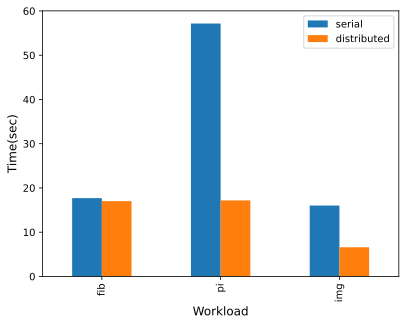

In [18]:
data = {'workload': ["fib", "pi", "img"],
        'serial' : [elapsed_fib_serial, elapsed_pi_serial, elapsed_img_serial],
        'distributed': [elapsed_fib_dist, elapsed_pi_dist, elapsed_img_dist]}

df = pd.DataFrame(data)
df.plot(x="workload", y=["serial", "distributed"], kind="bar")
plt.ylabel('Time(sec)', fontsize=12)
plt.xlabel('Workload', fontsize=12)
plt.grid(False)
plt.show()

最后还有一个需要注意的地方，当不需要计算时，使用 `ray.shutdown()` 将 Ray 关闭，否则 Ray 进程会一直在执行这个 Python 任务的电脑上运行。

In [19]:
ray.shutdown()